In [1]:
%load_ext autoreload
%autoreload 2
import sys
# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
#import sklearn.cluster.hierarchical as hclust
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import silhouette_score

from src import most_recent_mesonet_data
from src import most_recent_mesonet_time
from src import landtype_describe
from src.plotting_scripts import landtype
import os
import pandas as pd
import cartopy.crs as crs
import cartopy.feature as cfeature

Matplotlib created a temporary config/cache directory at /tmp/tmp.5rirQSpePz/matplotlib-9fb1sscp because the default path (/home/aevans/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
def plurality_plot(df):
    projPC = crs.PlateCarree()
    latN = df['lat'].max()+1
    latS = df['lat'].min()-1
    lonW = df['lon'].max()+1
    lonE = df['lon'].min()-1
    cLat = (latN + latS) / 2
    cLon = (lonW + lonE) / 2
    projLcc = crs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig, ax = plt.subplots(figsize=(12,9), subplot_kw={'projection': crs.PlateCarree()})
    ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle='--');
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.STATES)
    ax.xticklabels_top = False
    ax.ylabels_right = False
    ax.gridlines(crs=crs.PlateCarree(), draw_labels=True,
                    linewidth=2, color='black', alpha=0.5, linestyle='--')
    ax.scatter(x=df['lon'],
                                        y=df['lat'],
                                        c=df['color'],
                                        s=40,
                                        marker = 'o',
                                        transform=crs.PlateCarree()
                                        )
    ax.set_title('Mesonet Site Groups', size=16)
    ax.set_xlabel('Longitude',size=14)
    ax.set_ylabel('Latitude',size=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.grid()

In [8]:
df = pd.read_csv('/home/aevans/landtype/notebooks/features.csv').drop(columns='Unnamed: 0')
df.head()

,firstmode_count,firstmode_val,secondmode_count,secondmode_val,thirdmode_count,thirdmode_val,elev,std,variance,skew,med_dist,Mode,Count,Divide
0,102510.0,41,89978.0,43,89646.0,81,507.6140,78.927280,6227.304936,-0.137953,533.728027,22,84.0,3.070175
1,231578.0,41,38639.0,43,38113.0,81,518.2820,114.446243,13093.302806,0.554366,428.563965,28,225.0,7.970244
2,188167.0,82,43152.0,90,32775.0,81,276.1200,81.741875,6679.365616,1.134595,325.239990,23,23.0,0.840029
3,149074.0,41,38782.0,21,37181.0,11,90.1598,77.445227,5995.644516,0.642901,43.319595,23,100.0,3.590664
4,111398.0,43,99057.0,41,77808.0,81,470.3700,71.198890,5067.491291,-0.024945,520.739990,27,105.0,3.708937


In [27]:
import gower

distance_matrix = gower.gower_matrix(df)

array([[0.        , 0.219549  , 0.26231036, ..., 0.16939075, 0.3358374 ,
        0.26124108],
       [0.219549  , 0.        , 0.2082577 , ..., 0.23824976, 0.42812073,
        0.14836071],
       [0.26231036, 0.2082577 , 0.        , ..., 0.2563113 , 0.35698766,
        0.13210812],
       ...,
       [0.16939075, 0.23824976, 0.2563113 , ..., 0.        , 0.31144178,
        0.20297101],
       [0.3358374 , 0.42812073, 0.35698766, ..., 0.31144178, 0.        ,
        0.3943531 ],
       [0.26124108, 0.14836071, 0.13210812, ..., 0.20297101, 0.3943531 ,
        0.        ]], dtype=float32)

In [50]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [54]:
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(distance_matrix)
distances, indices = nbrs.kneighbors(distance_matrix)

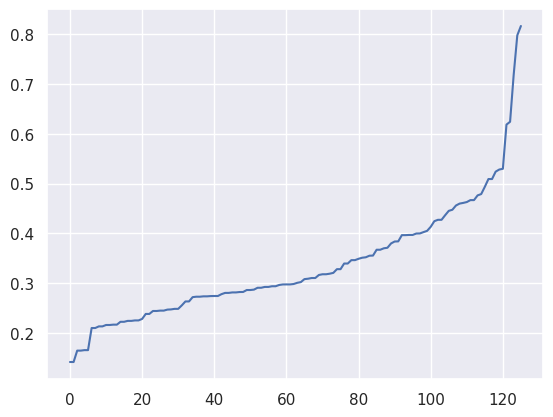

In [55]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [66]:
from sklearn.cluster import DBSCAN

# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=0.01, 
                        min_samples=5, 
                        metric="precomputed")

# Fitting the clustering algorithm
dbscan_cluster.fit(distance_matrix)

# Adding the results to a new column in the dataframe
df["cluster"] = dbscan_cluster.labels_

In [67]:
df['cluster'].unique()

array([-1])

In [68]:
#get lons and lats 
# This will return the most recent data avail on mesonet 
# this is my file path
ny_mesonet_data_path = '/home/aevans/nysm/archive/nysm/netcdf/proc/'
ok_mesonet_data_path = '/home/aevans/landtype/geoinfo.csv'

In [43]:
# create a dataframe of mesonet data ny
ny_df = most_recent_mesonet_data.current_time_mesonet_df(ny_mesonet_data_path)
ny_df = most_recent_mesonet_time.most_recent_time(ny_df, ny_mesonet_data_path)

In [44]:
ny_df_lons = ny_df['lon'].to_list()
ny_df_lats = ny_df['lat'].to_list()

In [45]:
colors = ['black', 'blue', 'white', 'coral', 'pink', 'red', 'magenta', 'gray', 'lime', 'forestgreen', 'green', 'olive', 'brown', 'slategray', 'darkorchid','plum', 'indigo', 'purple', 'yellow', 'gold', 'orange', 'cyan']
legend = [-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]


colordict = {}

for x,_ in enumerate(colors):
    colordict.update({legend[x] : colors[x]})

In [46]:
df['lon'] = ny_df_lons
df['lat'] = ny_df_lats
df['color'] = df['cluster'].map(colordict)

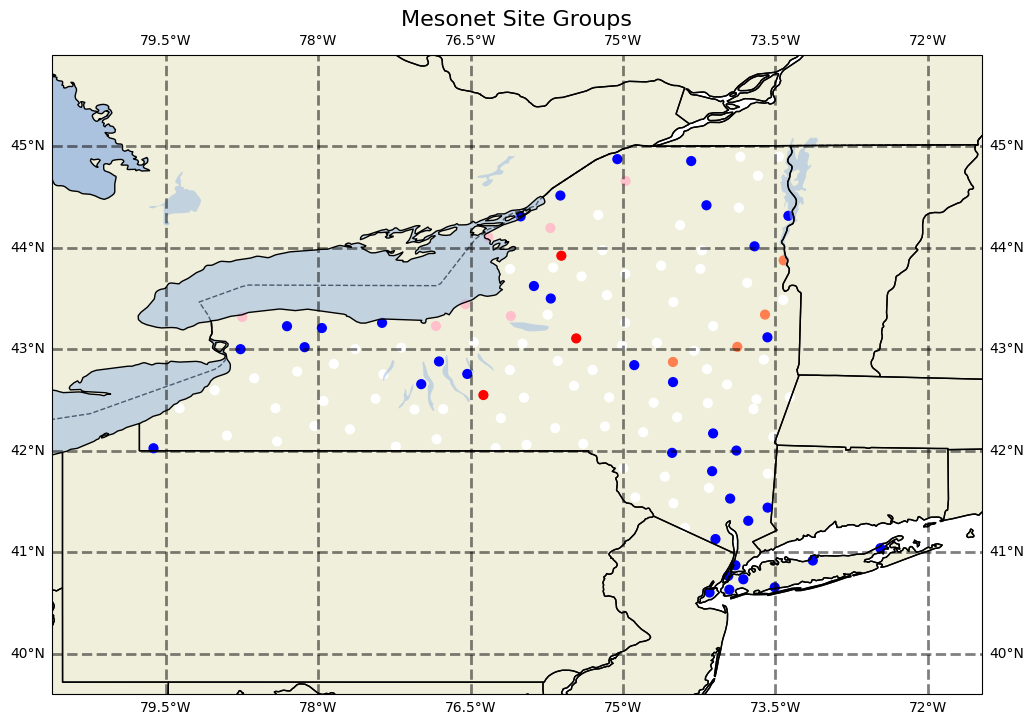

In [47]:
plurality_plot(df)